In [1]:
# Import libraries here
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

Connect to MongoDB server running at host `"localhost"` on port `27017`. Then connect to the `"air-quality"` database and assign the collection for Dar es Salaam to the variable name `dar`.

In [2]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
dar = db["dar-es-salaam"]

Determine the numbers assigned to all the sensor sites in the Dar es Salaam collection. Your submission should be a list of integers.

In [3]:
sites = dar.distinct("location")
sites

[10, 11, 12]

Determine which site in the Dar es Salaam collection has the most sensor readings (of any type, not just PM2.5 readings).

In [4]:
result =  dar.count_documents({"metadata.site":1})
readings_per_site = list(dar.aggregate(
    [
        {"$group": {"_id": "$location", "count": {"$count": {}}}}
    ]
))
readings_per_site

[{'_id': 10, 'count': 56},
 {'_id': 12, 'count': 56},
 {'_id': 11, 'count': 132396}]

Create a `wrangle` function that will extract the PM2.5 readings from the site that has the most total readings in the Dar es Salaam collection.

In [7]:
def wrangle(collection):
    
    results = collection.find(
        {"location": 11, "value_type": "P2"},
        projection={"value": 1, "timestamp": 1, "_id": 0},
    )
    
    # Read results into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

    # Remove outliers
    df = df[df["value"] < 100]

    # Resample and forward-fill
    y = df["value"].resample("1H").mean().fillna(method='ffill')
    
    return y

Use your `wrangle` function to query the `dar` collection and return your cleaned results.

In [8]:
y = wrangle(dar)
y.head()

timestamp
2017-10-08 13:00:00+03:00     8.215000
2017-10-08 14:00:00+03:00    16.405333
2017-10-08 15:00:00+03:00    16.405333
2017-10-08 16:00:00+03:00    16.405333
2017-10-08 17:00:00+03:00    16.405333
Freq: H, Name: value, dtype: float64

Create a time series plot of the readings in `y`. Label your x-axis `"Date"` and your y-axis `"PM2.5 Level"`. Use the title `"Dar es Salaam PM2.5 Levels"`.

<Axes: title={'center': 'Dar es Salaam PM2.5 Levels'}, xlabel='Date', ylabel='PM2.5 Level'>

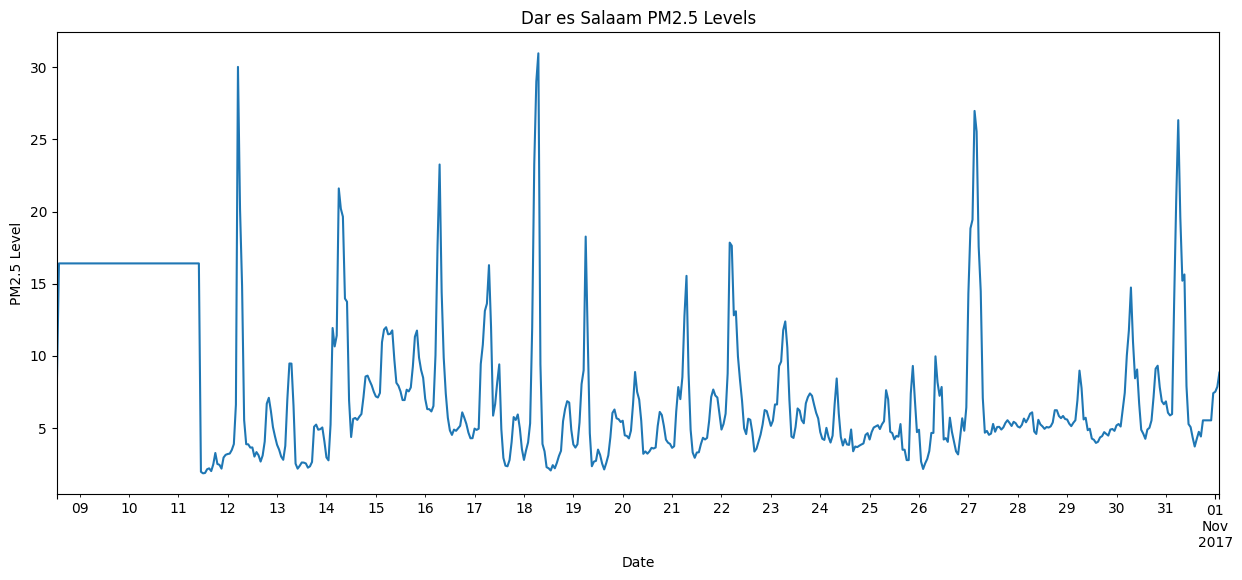

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(xlabel="Date", ylabel="PM2.5 Level",title="Dar es Salaam PM2.5 Levels",ax=ax)

Plot the rolling average of the readings in `y`. Use a window size of `168` (the number of hours in a week). Label your x-axis `"Date"` and your y-axis `"PM2.5 Level"`. Use the title `"Dar es Salaam PM2.5 Levels, 7-Day Rolling Average"`.

<Axes: title={'center': 'Dar es Salaam PM2.5 Levels, 7-Day Rolling Average'}, xlabel='Date', ylabel='PM2.5 Level'>

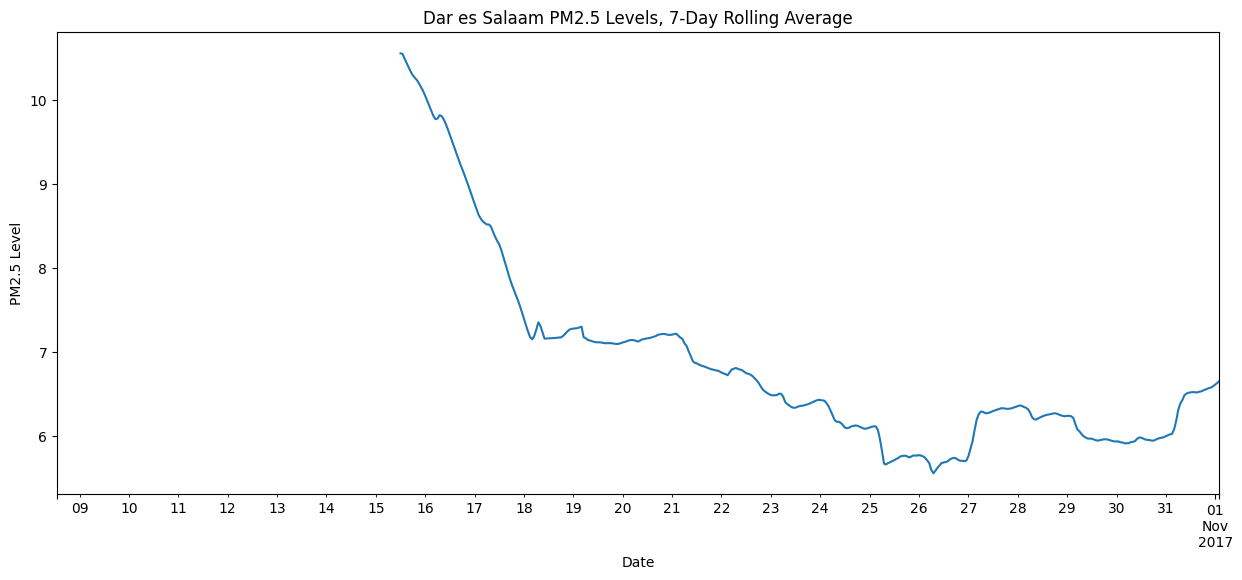

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(168).mean().plot(ax=ax, xlabel="Date", ylabel="PM2.5 Level", title="Dar es Salaam PM2.5 Levels, 7-Day Rolling Average")

Create an ACF plot for the data in `y`.

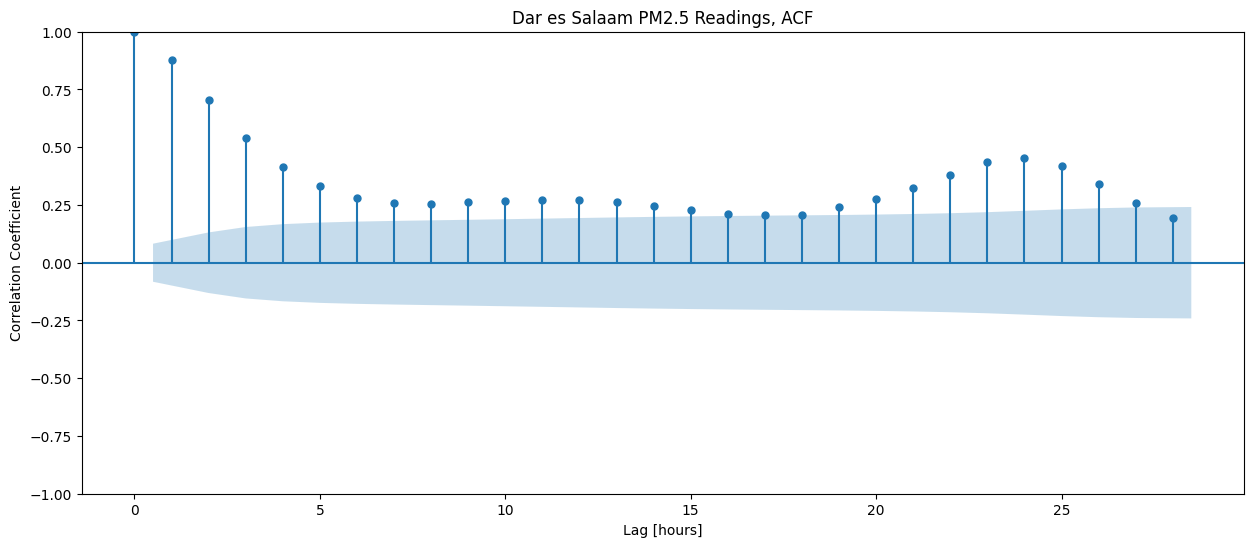

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF");

Create an PACF plot for the data in `y`.

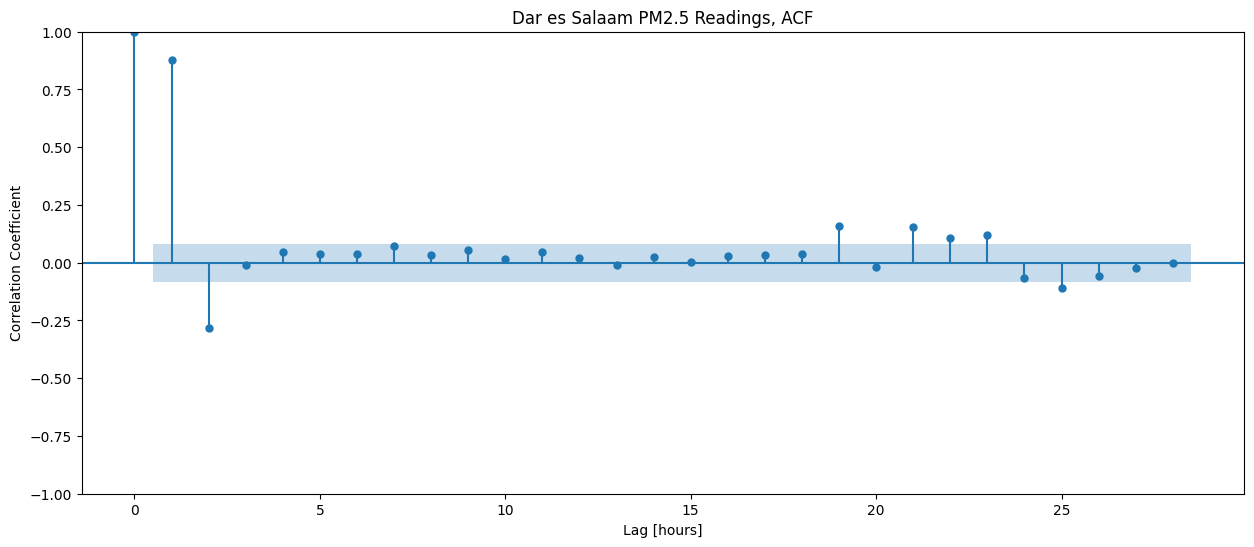

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF");

## Split

Split `y` into training and test sets. The first 90% of the data should be in your training set. The remaining 10% should be in the test set.

In [13]:
cutoff_test = int(len(y) * 0.9)
y_train = y[:cutoff_test]
y_test = y[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (509,)
y_test shape: (57,)


# Build Model

## Baseline

Establish the baseline mean absolute error for your model.

In [14]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 7.722390480697428
Baseline MAE: 4.135132241128031


## Iterate

Use a `for` loop to train your AR model on using settings for `p` from 1 to 30. Each time you train a new model, calculate its mean absolute error and append the result to the list `maes`. Then store your results in the Series `mae_series`.

In [15]:
p_params = range(1, 31)
maes = []
for p in p_params:
    start_time = time.time()
    model = AutoReg(y_train, lags=p).fit()
    elapsed_time = round(time.time() - start_time, 2)
    print(f"Trained AutoReg {p} in {elapsed_time} seconds.")
    y_pred = model.predict().dropna()
    mae = mean_absolute_error(y_train.loc[y_pred.index], y_pred)
    maes.append(mae)
    
    
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

Trained AutoReg 1 in 0.01 seconds.
Trained AutoReg 2 in 0.01 seconds.
Trained AutoReg 3 in 0.01 seconds.
Trained AutoReg 4 in 0.01 seconds.
Trained AutoReg 5 in 0.01 seconds.
Trained AutoReg 6 in 0.01 seconds.
Trained AutoReg 7 in 0.01 seconds.
Trained AutoReg 8 in 0.01 seconds.
Trained AutoReg 9 in 0.01 seconds.
Trained AutoReg 10 in 0.01 seconds.
Trained AutoReg 11 in 0.01 seconds.
Trained AutoReg 12 in 0.01 seconds.
Trained AutoReg 13 in 0.01 seconds.
Trained AutoReg 14 in 0.01 seconds.
Trained AutoReg 15 in 0.01 seconds.
Trained AutoReg 16 in 0.01 seconds.
Trained AutoReg 17 in 0.01 seconds.
Trained AutoReg 18 in 0.01 seconds.
Trained AutoReg 19 in 0.01 seconds.
Trained AutoReg 20 in 0.01 seconds.
Trained AutoReg 21 in 0.01 seconds.
Trained AutoReg 22 in 0.01 seconds.
Trained AutoReg 23 in 0.01 seconds.
Trained AutoReg 24 in 0.01 seconds.
Trained AutoReg 25 in 0.01 seconds.
Trained AutoReg 26 in 0.01 seconds.
Trained AutoReg 27 in 0.01 seconds.
Trained AutoReg 28 in 0.01 seconds.
T

1    1.344684
2    1.291514
3    1.293944
4    1.288142
5    1.286055
Name: mae, dtype: float64

Look through the results in `mae_series` and determine what value for `p` provides the best performance. Then build and train `final_model` using the best hyperparameter value.

In [16]:
mae_series

1     1.344684
2     1.291514
3     1.293944
4     1.288142
5     1.286055
6     1.284627
7     1.278463
8     1.278757
9     1.276485
10    1.276816
11    1.268489
12    1.263972
13    1.264979
14    1.267638
15    1.269637
16    1.272633
17    1.276191
18    1.275288
19    1.289372
20    1.296284
21    1.283211
22    1.280393
23    1.270609
24    1.276738
25    1.266596
26    1.269852
27    1.270844
28    1.273343
29    1.274431
30    1.273061
Name: mae, dtype: float64

In [17]:
best_p = 12
best_model = AutoReg(y_train, lags=12, old_names=True).fit()

 Calculate the training residuals for `best_model` and assign the result to `y_train_resid`.

In [18]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2017-10-09 01:00:00+03:00    1.202491
2017-10-09 02:00:00+03:00    1.007076
2017-10-09 03:00:00+03:00    1.007076
2017-10-09 04:00:00+03:00    1.007076
2017-10-09 05:00:00+03:00    1.007076
Freq: H, Name: residuals, dtype: float64

Create a histogram of `y_train_resid`.

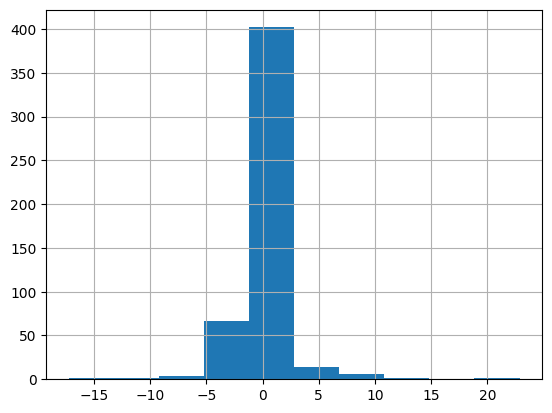

In [19]:
# Plot histogram of residuals
y_train_resid.hist()
plt.xlabel = "Residuals"
plt.ylabel = "Frequency"
plt.title = "Best Model, Training Residuals"

Create an ACF plot for `y_train_resid`.

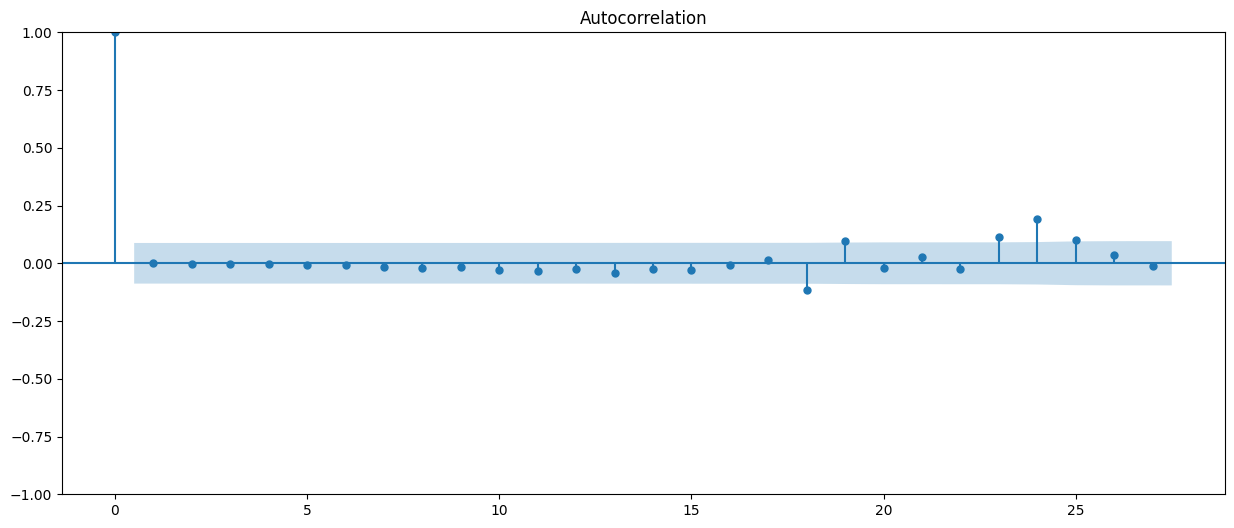

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel = "Lag [hours]"
plt.ylabel = "Correlation Coefficient"
plt.title = "Dar es Salaam, Training Residuals ACF"

## Evaluate

Perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`.

In [21]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=28).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred) # series can append
    history = history.append(y_test[next_pred.index])
    
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2017-10-29 18:00:00+03:00    5.065875
2017-10-29 19:00:00+03:00    5.097594
2017-10-29 20:00:00+03:00    4.827223
2017-10-29 21:00:00+03:00    4.713308
2017-10-29 22:00:00+03:00    5.264647
Freq: H, Name: prediction, dtype: float64